# Drawing the likelihood contours

Amongst the material to be presented in the final results is the contours in branching fraction space.  Here I will draw the contours based on the assumption that the pdf for the branching fractions can be approximated by a three (or four if we include the hadronic fraction) dimensional Gaussian.  

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import multivariate_normal, norm
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 53007,
  "iopub_port": 35505,
  "stdin_port": 56221,
  "control_port": 50231,
  "hb_port": 45875,
  "ip": "127.0.0.1",
  "key": "ecd730fb-68b2e40691badaf71c3685fc",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-c9d7b1d7-1cbe-4e5a-9d54-2400f67da8eb.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## Test the machinery first

The contours will be drawn as two dimendional projections of the three dimensional Gaussian that is determined from the likelihood.  To understand how this is done, I will first carry out the problem in the easier to visualize two to one dimensional case.  When doing the projection, we can approach it in two ways: 

   1. marginalize over the dimension that is not being displayed, i.e., $P(x) = \int_{-\infty}^{\infty} P(x, y) dy$,
   2. use the optimal value of the dimension not being displayed.  This can be achieved by finding the line (or (hyper)plane) defined by the eigenvectors of the covariance matrix.
   
I will compare these two approaches here.  

*After messing around with this, I've come to the conclusion that you just draw the projection using the appropriate sub-matrix of the full covariance matrix.  So for the two to one dimensional case, this means the projections are just defined by the variances for the x and y component.  I suppose this is mostly obvious, but it took this exercise for me to understand it.  I think this result ends up being equivalent to the marginal distribution.*

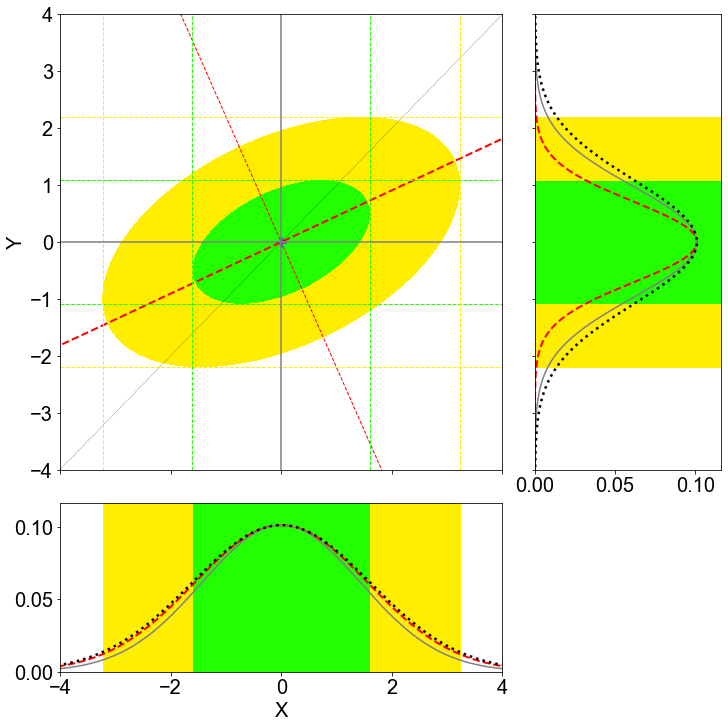

In [2]:
# 2D case
fig = plt.figure(facecolor='white', figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(10, 10)

# define the distribution
mean = [0, 0]
cov = np.array([[2.6, 0.8], 
                [0.8, 1.2]]) 
sig_x = np.sqrt(cov[0, 0])
sig_y = np.sqrt(cov[1, 1])
fnorm = multivariate_normal(mean=mean, cov=cov)

# calculate eigenvalues for drawing projections
eigenvals, eigenvecs = np.linalg.eig(cov)

# generate sample points
x = np.linspace(-5, 5, 1e3)
X, Y = np.meshgrid(x, x)
pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y

# make the plots
ax = fig.add_subplot(gs[:6, :6])
plt.setp(ax.get_xticklabels(), visible=False)
clvls = [0, 0.5, 2]
ax.plot([0], [0], marker='+', markersize=10, markeredgewidth=3)
slope1, slope2 = eigenvecs[1][0]/eigenvecs[1][1], eigenvecs[0][0]/eigenvecs[0][1]
ax.plot(x, slope1*x, 'r--', linewidth=2)
ax.plot(x, slope2*x, 'r--', linewidth=1)
ax.plot(x, x, 'k:', linewidth=0.5)
cf = ax.contourf(X, Y, -np.log(fnorm.pdf(pos)/fnorm.pdf([0, 0])), levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])

# y intervals
ax.plot([-4, 4], [2*sig_y, 2*sig_y], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([-4, 4], [-2*sig_y, -2*sig_y], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([-4, 4], [sig_y, sig_y], color='#22FF00', linestyle='--', linewidth=1.)
ax.plot([-4, 4], [-sig_y, -sig_y], color='#22FF00', linestyle='--', linewidth=1.)

# y intervals
ax.plot([2*sig_x, 2*sig_x], [-4, 4], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([-2*sig_x, -2*sig_x], [-4, 4], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([sig_x, sig_x], [-4, 4], color='#22FF00', linestyle='--', linewidth=1.)
ax.plot([-sig_x, -sig_x], [-4, 4], color='#22FF00', linestyle='--', linewidth=1.)

# origin
ax.plot([0, 0], [-4, 4], color='gray', linewidth=1.5)
ax.plot([-4, 4], [0, 0], color='gray', linewidth=1.5)

ax.set_ylabel('Y')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

# y projection
ax_y = fig.add_subplot(gs[:6, 6:], sharey=ax)
plt.setp(ax_y.get_yticklabels(), visible=False)
xy = np.vstack([x/slope1, x]) if slope1 != 0 else np.vstack([np.zeros_like(x), x])
fproj_y = fnorm.pdf(xy.T)
ax_y.plot(fproj_y, x , 'r--', linewidth=2)

xy = np.vstack([np.zeros_like(x), x])
fproj_y_alt = fnorm.pdf(xy.T)
ax_y.plot(fproj_y_alt, x, color='gray', linewidth=1.5)

fnom_y = norm.pdf(x, loc=mean[0], scale=sig_y)
norm_factor = fproj_y_alt.max()/fnom_y.max()
ax_y.plot(norm_factor*fnom_y, x,'k:')

ax_y.fill_between([0, sig_y], [-sig_y, -sig_y], [sig_y, sig_y], color='#22FF00')
ax_y.fill_between([0, sig_y], [-2*sig_y, -2*sig_y], [-sig_y, -sig_y], color='#FFEE00')
ax_y.fill_between([0, sig_y], [sig_y, sig_y], [2*sig_y, 2*sig_y], color='#FFEE00')

ax_y.set_xlim(0, 1.15*fproj_y.max())

# x projection
ax_x = fig.add_subplot(gs[6:, :6], sharex=ax) 
xy = np.vstack([x, slope1*x]).T
fproj_x = fnorm.pdf(xy)
ax_x.plot(x, fproj_x, 'r--', linewidth=2)

xy_alt = np.vstack([x, np.zeros_like(x)]).T
fproj_x_alt = fnorm.pdf(xy_alt)
ax_x.plot(x, fproj_x_alt, color='gray', linewidth=1.5)

fnom_x = norm.pdf(x, loc=mean[0], scale=sig_x)
norm_factor = fproj_x_alt.max()/fnom_x.max()
ax_x.plot(x, norm_factor*fnom_x, 'k:')

ax_x.fill_betweenx([0, sig_x], [-sig_x, -sig_x], [sig_x, sig_x], color='#22FF00')
ax_x.fill_betweenx([0, sig_x], [-2*sig_x, -2*sig_x], [-sig_x, -sig_x], color='#FFEE00')
ax_x.fill_betweenx([0, sig_x], [sig_x, sig_x], [2*sig_x, 2*sig_x], color='#FFEE00')

ax_x.set_ylim(0, 1.15*fproj_x.max())
ax_x.set_xlabel('X')

gs.tight_layout(fig, h_pad=0.)
plt.show()

## Draw contours from full fit

In [3]:
# configure, get the input data, and do any additional processing that is needed

# get data for Asimov dataset fit
parameters_asimov = pd.read_csv('data/model_parameters_asimov.csv', index_col='name')
corr_asimov = pd.read_csv('local_data/corr_table_full_asimov.csv', index_col='label')

# define multivariate normal distributions
val_fit_asimov = parameters_asimov.loc[['beta_e', 'beta_mu', 'beta_tau'], 'val_fit'].values
err_fit_asimov = parameters_asimov.loc[['beta_e', 'beta_mu', 'beta_tau'], 'err_fit'].values
cov_asimov = corr_asimov.iloc[:3, :3].values*np.outer(err_fit_asimov, err_fit_asimov)

# get data for real data fit
parameters_unblinded = pd.read_csv('data/model_parameters_unblinded.csv', index_col='name')
corr_unblinded = pd.read_csv('local_data/corr_table_full_unblinded.csv', index_col='label')

# define multivariate normal distributions
val_fit_unblinded = parameters_unblinded.loc[['beta_e', 'beta_mu', 'beta_tau'], 'val_fit'].values
err_fit_unblinded = parameters_unblinded.loc[['beta_e', 'beta_mu', 'beta_tau'], 'err_fit'].values
cov_unblinded = corr_unblinded.iloc[:3, :3].values*np.outer(err_fit_unblinded, err_fit_unblinded)
f_unblinded = multivariate_normal(mean=val_fit_unblinded, cov=cov_unblinded)

val_fit_unblinded = val_fit_asimov
err_fit_unblinded = err_fit_asimov
cov_unblinded = cov_asimov

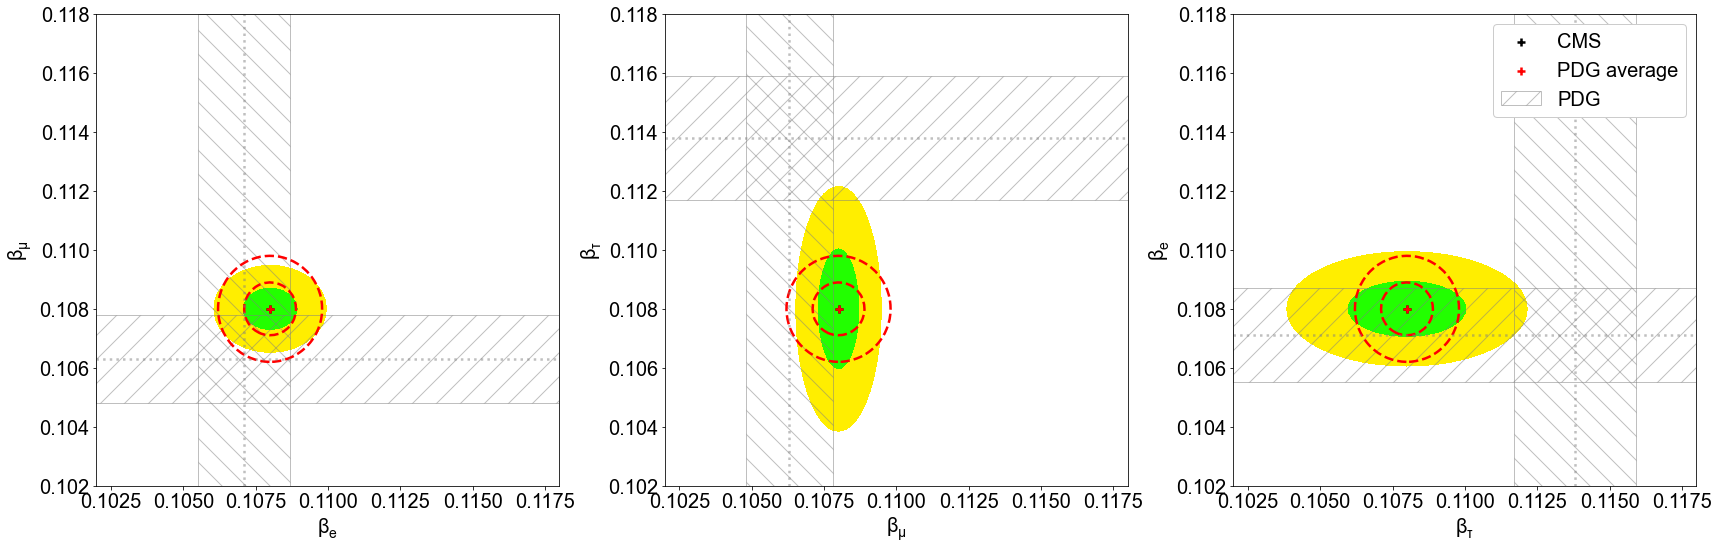

In [5]:
# plot the cost
fig, axes = plt.subplots(1, 3, figsize=(24, 8), facecolor='white', sharex=True, sharey=False)

# plot options
scan_range = (0.102, 0.118)
clvls = [0., 0.5, 2]

# define sample points
scan_vals = np.linspace(scan_range[0], scan_range[1], 100)
X, Y = np.meshgrid(scan_vals, scan_vals)
pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y
    
# PDG average (this can/should be done with the full covariance)
mu = 0.1080
sigma = 0.0009
f_pdg = multivariate_normal(mean=[mu, mu], cov=[[sigma**2, 0.], [0., sigma**2]])
nll_pdg = -np.log(f_pdg.pdf(pos)/f_pdg.pdf([0.108, 0.108])) # 

# PDG exclusive BR
pdg_e = (0.1071, 0.0016)
pdg_mu = (0.1063, 0.0015)
pdg_tau = (0.1138, 0.0021)

# electron vs. muon
cov_emu = cov_unblinded[:2, :2]
f_emu = multivariate_normal(mean=val_fit_unblinded[:2], cov=cov_unblinded[:2, :2])
nll_emu = -np.log(f_emu.pdf(pos)/f_emu.pdf(val_fit_unblinded[:2]))

ax = axes[0]
ax.contourf(X, Y, nll_emu, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter([val_fit_unblinded[0]], [val_fit_unblinded[1]], marker='+', c='k', label='CMS')
ax.contour(X, Y, nll_pdg, levels=clvls, linestyles='--', colors='r')
ax.scatter([mu], [mu], marker='+', c='r', label='PDG average')

ax.fill_between(scan_range, 2*[pdg_mu[0] - pdg_mu[1], ], 2*[pdg_mu[0] + pdg_mu[1], ], facecolor='none', edgecolor='gray', hatch='/', alpha=0.5)
ax.plot(scan_range, 2*[pdg_mu[0],], color='gray', linestyle=':', alpha=0.5)
ax.fill_betweenx(scan_range, 2*[pdg_e[0] - pdg_e[1], ], 2*[pdg_e[0] + pdg_e[1], ], facecolor='none', edgecolor='gray', hatch='\\', alpha=0.5)
ax.plot(2*[pdg_e[0],], scan_range, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel(r'$\beta_{e}$')
ax.set_ylabel(r'$\beta_{\mu}$')
ax.set_xlim(scan_range)
ax.set_ylim(scan_range)

# muon vs. tau
cov_mutau = cov_unblinded[1:, 1:]
f_mutau = multivariate_normal(mean=val_fit_unblinded[1:], cov=cov_unblinded[1:, 1:])
nll_mutau = -np.log(f_mutau.pdf(pos)/f_mutau.pdf(val_fit_unblinded[1:]))

ax = axes[1]
ax.contourf(X, Y, nll_mutau, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter([val_fit_unblinded[1]], [val_fit_unblinded[2]], marker='+', c='k', label='CMS')
ax.contour(X, Y, nll_pdg, levels=clvls, linestyles='--', colors='r')
ax.scatter([mu], [mu], marker='+', c='r', label='PDG average')

ax.fill_between(scan_range, 2*[pdg_tau[0] - pdg_tau[1], ], 2*[pdg_tau[0] + pdg_tau[1], ], facecolor='none', edgecolor='gray', hatch='/', alpha=0.5)
ax.plot(scan_range, 2*[pdg_tau[0],], color='gray', linestyle=':', alpha=0.5)
ax.fill_betweenx(scan_range, 2*[pdg_mu[0] - pdg_mu[1], ], 2*[pdg_mu[0] + pdg_mu[1], ], facecolor='none', edgecolor='gray', hatch='\\', alpha=0.5)
ax.plot(2*[pdg_mu[0],], scan_range, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel(r'$\beta_{\mu}$')
ax.set_ylabel(r'$\beta_{\tau}$')
ax.set_xlim(scan_range)
ax.set_ylim(scan_range)

## electron vs. tau
cov_etau = cov_unblinded[[2, 0], [2, 0]]
f_etau = multivariate_normal(mean=val_fit_unblinded[[2, 0]], cov=cov_etau)
nll_etau = -np.log(f_etau.pdf(pos)/f_etau.pdf(val_fit_unblinded[[2, 0]]))

ax = axes[2]
ax.contourf(X, Y, nll_etau, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter([val_fit_unblinded[2]], [val_fit_unblinded[0]], marker='+', c='k', label='CMS')
ax.contour(X, Y, nll_pdg, levels=clvls, linestyles='--', colors='r')
ax.scatter([mu], [mu], marker='+', c='r', label='PDG average')

ax.fill_between(scan_range, 2*[pdg_e[0] - pdg_e[1], ], 2*[pdg_e[0] + pdg_e[1], ], facecolor='none', edgecolor='gray', hatch='/', alpha=0.5, label='PDG')
ax.plot(scan_range, 2*[pdg_e[0],], color='gray', linestyle=':', alpha=0.5)
ax.fill_betweenx(scan_range, 2*[pdg_tau[0] - pdg_tau[1], ], 2*[pdg_tau[0] + pdg_tau[1], ], facecolor='none', edgecolor='gray', hatch='\\', alpha=0.5)
ax.plot(2*[pdg_tau[0],], scan_range, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel(r'$\beta_{\tau}$')
ax.set_ylabel(r'$\beta_{e}$')
ax.set_xlim(scan_range)
ax.set_ylim(scan_range)

ax.legend(loc=1, framealpha=1.)

plt.tight_layout()
plt.savefig('plots/result_contours_test.pdf')
plt.savefig('plots/result_contours_test.png')
plt.show()